In [85]:
import os
import time
import rasterio
import numpy as np
import pandas as pd
from osgeo import gdal
import geopandas as gpd
from shapely import geometry
from rasterio.plot import show
import matplotlib.pyplot as plt
from osgeo import gdal, gdalconst,ogr, osr

# 数据查看

In [90]:
driver = ogr.GetDriverByName('ESRI Shapefile')
rs = rasterio.open('D:/zhuyupeng/数据集-张朝/生育期/V3_2011_2020_Beijing.tif')

In [91]:
rs.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 7761,
 'height': 6001,
 'count': 11,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, 115.41671551354548,
        0.0, -0.00026949458523585647, 41.05911702819415)}

In [92]:
rs.descriptions

('y2011',
 'y2012',
 'y2013',
 'y2014',
 'y2015',
 'y2016',
 'y2017',
 'y2018',
 'y2019',
 'y2020',
 'maize_type')

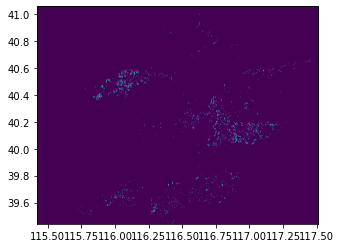

<AxesSubplot:>

In [93]:
show(rs)

# 数据获取

In [94]:
def rasterToPoints(rasterfile, nodata=None, v_name=None):
    
    """
    :rasterfile: 待执行栅格转点的栅格文件
    :nodata:栅格中的无数据值,默认取栅格的最小值
    :v_name:导出表格中栅格值所在列的名称，默认为栅格的文件名
    :return:x、y、value
    
    """
    # numpy禁用科学计数法,pandas中存储浮点型时只保留四位小数
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    rds = gdal.Open(rasterfile)  # 数据读取
    if rds.RasterCount != 1:
        print("Warning, RasterCount > 1")

    cols = rds.RasterXSize
    rows = rds.RasterYSize
    band = rds.GetRasterBand(1)  # 可更改括弧里数字以便更改土层
    transform = rds.GetGeoTransform() #栅栏地理坐标转为经纬度
    
    print(transform)
    
    x_origin = transform[0]
    y_origin = transform[3]
    pixel_width = transform[1]
    pixel_height = transform[5]
    
    if (pixel_height + pixel_width) != 0:
        print("Warning, pixelWidth != pixelHeight")
    
    # 读取栅格，数组与数列转换
    values = np.array(band.ReadAsArray())
    x = np.arange(x_origin + pixel_width * 0.5, x_origin + (cols + 0.5) * pixel_width, pixel_width)
    y = np.arange(y_origin + pixel_height*0.5, y_origin + (rows+0.5) * pixel_height, pixel_height)
    px, py = np.meshgrid(x, y)
    
    if v_name is None:
        v_name = os.path.splitext(os.path.split(rasterfile)[1])[0]
    dataset = {"Longitude": px.ravel(),
               "latitude": py.ravel(),
               v_name: values.ravel()}
    df_temp = pd.DataFrame(dataset, dtype="float32")#形成DateFrame

    # 删除缺失值
    if nodata is None:
        nodata = df_temp[v_name].min()
        df_temp = df_temp[df_temp[v_name] != nodata]
    else:
        df_temp = df_temp[df_temp[v_name] != nodata]

    df_temp.index = range(len(df_temp))
    
    return df_temp

In [96]:
if __name__ == "__main__":
    # 禁用科学计数法
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    # 执行栅格转点，并计时
    s = time.time()
    # in_tif是输入栅格，刚才裁剪的结果
    in_tif = r"D:/zhuyupeng/数据集-张朝/生育期/V3_2011_2020_Beijing.tif"
    outfile = rasterToPoints(in_tif, v_name="values") # v_name是你自己定义的栅格字段列名称
    outfile.to_csv("data.csv",index=None) # 导出csv文件
    e = time.time()
    print("time used {0}s".format(e-s)) 

Warning, RasterCount > 1
(115.41671551354548, 0.00026949458523585647, 0.0, 41.05911702819415, 0.0, -0.00026949458523585647)
time used 3.009571075439453s


In [135]:
#数据读取
cs = pd.read_csv('data.csv')
cs

,Longitude,latitude,values
0,116.6250,41.0067,124.0000
1,116.6253,41.0067,141.0000
2,116.6255,41.0067,141.0000
3,116.6258,41.0067,145.0000
4,116.6261,41.0067,151.0000
...,...,...,...
301796,116.4272,39.4434,167.0000
301797,116.4274,39.4434,167.0000
301798,116.4272,39.4431,168.0000
301799,116.4274,39.4428,150.0000


In [99]:
cs['values'].mean()

143.9876872508706

In [141]:
#获取范围内的数值
cs1 = cs[(cs['Longitude']>116.00671551354548) &(cs['Longitude']<116.10671551354548)&(cs['latitude']>40.00911702819415) & (cs['latitude']<41.00911702819415)]

In [142]:
#求均值
cs1['values'].mean()

150.0710610002891

# 数据获取

In [129]:
#栅栏与矢量数据互转
def raster2poly(raster, outshp):
    inraster = gdal.Open(raster)  # 读取路径中的栅格数据
    inband = inraster.GetRasterBand(1)  # 这个波段就是最后想要转为矢量的波段，如果是单波段数据的话那就都是1
    prj = osr.SpatialReference()
    prj.ImportFromWkt(inraster.GetProjection())  # 读取栅格数据的投影信息，用来为后面生成的矢量做准备

    drv = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outshp):  # 若文件已经存在，则删除它继续重新做一遍
        drv.DeleteDataSource(outshp)
    Polygon = drv.CreateDataSource(outshp)  # 创建一个目标文件
    Poly_layer = Polygon.CreateLayer(raster[:-4], srs=prj, geom_type=ogr.wkbMultiPolygon)  # 对shp文件创建一个图层，定义为多个面类
    newField = ogr.FieldDefn('value', ogr.OFTReal)  # 给目标shp文件添加一个字段，用来存储原始栅格的pixel value
    Poly_layer.CreateField(newField)

    gdal.FPolygonize(inband, None, Poly_layer, 0)  # 核心函数，执行的就是栅格转矢量操作
    Polygon.SyncToDisk()
    Polygon = None

In [132]:
raster2poly('D:/zhuyupeng/数据集-张朝/生育期/V3_2011_2020_Beijing.tif','D:/zhuyupeng/数据集-张朝/生育期/V3_2011_2020_Beijing.shp')

In [131]:
shp = gpd.read_file('D:/zhuyupeng/数据集-张朝/生育期/V3_2011_2020_Beijing.shp')
shp

,value,geometry
0,124.0000,"POLYGON ((116.62486 41.00684, 116.62513 41.006..."
1,141.0000,"POLYGON ((116.62513 41.00684, 116.62567 41.006..."
2,145.0000,"POLYGON ((116.62567 41.00684, 116.62594 41.006..."
3,151.0000,"POLYGON ((116.62594 41.00684, 116.62648 41.006..."
4,150.0000,"POLYGON ((116.62648 41.00684, 116.62675 41.006..."
...,...,...
211959,167.0000,"POLYGON ((116.42705 39.44350, 116.42759 39.443..."
211960,168.0000,"POLYGON ((116.42705 39.44323, 116.42732 39.443..."
211961,0.0000,"POLYGON ((115.41672 41.05912, 117.50826 41.059..."
211962,150.0000,"POLYGON ((116.42732 39.44296, 116.42759 39.442..."


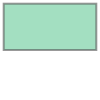

In [133]:
shp.geometry[1]

In [134]:
shp['value'].mean()

139.64858655243344

In [139]:
shp['value'].mean()

139.64858655243344

In [143]:
shp1 = shp.cx[116.00671551354548:116.10671551354548, 40.00:41.00]
shp1['value'].mean()

146.1998764434729